In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR,setup_pls_models_exh,LinearRidge,CustomWrapper

In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name = "mango_684_990.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.01")

In [5]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape

n_features = ncol - 1-len(id_cols)
n_comps = [i*5 for i in range(1,21) if i*5 < n_features]

dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.01\mango_684_990


In [6]:
#todo write a summary

ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [7]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [8]:
#setup
scores_df_pcr = None
scores_df_pcr_final = None
for n_component in n_comps:
    save_loc = log_dir/f"PCR_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()

    local_logger_name = f"pcr_{n_component}"
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger = logging.getLogger(local_logger_name)

    scheme = ev.PCAScheme(logger=local_logger_name,whiten=False,n_components=n_component)

    local_logger.info(f"Running PCR with {n_component} components")
    scores_sk, preds_sk, model_states_sk , train_time_sk, test_time_sk,_ = eval.evaluate(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_sk_final, _, model_states_sk_final , _, _,_= eval.build(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    #for fold,nested in model_states_sk.items():
    #    for name,model in nested.items():
    #        model.save(save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_sk_final.items():
    #    model.save(save_loc/(f"{name}_final"))

    local_logger.info(f"Train times: {train_time_sk}")
    local_logger.info(f"Test times: {test_time_sk}")
    local_logger.info(f"Scores: {scores_sk}")
    for key,value in ut.flip_dicts(scores_sk).items():
        local_logger.info(f"{key}: {value}")

    preds_sk.to_csv(save_loc/ (f"predictions_pcr" + ".csv"), index=False)
    plot_preds_and_res(preds_sk,name_lambda=lambda x:f"PCR with {x} components",save_lambda= lambda x:f"pcr_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_sk)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr is None:
            scores_df_pcr =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr=scores_df_pcr.append([{**record1,**record}],ignore_index=True)
        
    flipped = ut.flip_dicts(scores_sk_final)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr_final is None:
            scores_df_pcr_final =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr_final=scores_df_pcr_final.append([{**record1,**record}],ignore_index=True)


Running PCR with 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.1411,lwr_k=10:1.0291,lwr_k=20:2.5138,lwr_k=30:3.0687,lwr_k=40:3.2958,lwr_k=50:3.4343,lwr_k=100:3.7919,lwr_k=200:4.0268,lwr_k=300:4.1368,lwr_k=400:4.2132,lwr_k=500:4.2641,lwr_k=600:4.3231,lwr_k=700:4.3687,lwr_k=800:4.4099,lwr_k=900:4.4417,lwr_k=1000:4.4699'
Tested (test) on 1905 instances with mean losses of: lr:5.1942,lwr_k=10:8.7652,lwr_k=20:4.1409,lwr_k=30:3.9828,lwr_k=40:3.923,lwr_k=50:3.9292,lwr_k=100:3.9719,lwr_k=200:4.1222,lwr_k=300:4.1582,lwr_k=400:4.1825,lwr_k=500:4.2225,lwr_k=600:4.2751,lwr_k=700:4.3282,lwr_k=800:4.3723,lwr_k=900:4.4195,lwr_k=1000:4.4461'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:5.109,lwr_k=10:1.1577,lwr_k=20:2.6487

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:1.8763,lwr_k=10:0.0,lwr_k=20:0.3128,lwr_k=30:0.5704,lwr_k=40:0.7201,lwr_k=50:0.8282,lwr_k=100:1.0614,lwr_k=200:1.1963,lwr_k=300:1.2555,lwr_k=400:1.2895,lwr_k=500:1.3074,lwr_k=600:1.336,lwr_k=700:1.358,lwr_k=800:1.3782,lwr_k=900:1.398,lwr_k=1000:1.4191'
Tested (test) on 1905 instances with mean losses of: lr:1.8426,lwr_k=10:18.3051,lwr_k=20:2.1826,lwr_k=30:1.4233,lwr_k=40:1.3708,lwr_k=50:1.3044,lwr_k=100:1.3079,lwr_k=200:1.3434,lwr_k=300:1.3584,lwr_k=400:1.3616,lwr_k=500:1.3705,lwr_k=600:1.3876,lwr_k=700:1.3977,lwr_k=800:1.4116,lwr_k=900:1.4289,lwr_k=1000:1.4475'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:1.8049,lwr_k=10:0.0,lwr_k=20:0.3494,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8339,lwr_k=10:0.0,lwr_k=20:0.0463,lwr_k=30:0.1748,lwr_k=40:0.2557,lwr_k=50:0.313,lwr_k=100:0.4538,lwr_k=200:0.5447,lwr_k=300:0.5799,lwr_k=400:0.5997,lwr_k=500:0.6169,lwr_k=600:0.6324,lwr_k=700:0.6443,lwr_k=800:0.6525,lwr_k=900:0.6607,lwr_k=1000:0.6704'
Tested (test) on 1905 instances with mean losses of: lr:0.8371,lwr_k=10:4.1532,lwr_k=20:3.193,lwr_k=30:0.9927,lwr_k=40:0.8403,lwr_k=50:0.7756,lwr_k=100:0.6778,lwr_k=200:0.6754,lwr_k=300:0.6743,lwr_k=400:0.6704,lwr_k=500:0.672,lwr_k=600:0.6795,lwr_k=700:0.686,lwr_k=800:0.6887,lwr_k=900:0.6927,lwr_k=1000:0.6995'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8377,lwr_k=10:0.0,lwr_k=20:0.0483,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8304,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.1024,lwr_k=40:0.188,lwr_k=50:0.2513,lwr_k=100:0.4095,lwr_k=200:0.5173,lwr_k=300:0.5602,lwr_k=400:0.5815,lwr_k=500:0.6003,lwr_k=600:0.6157,lwr_k=700:0.6276,lwr_k=800:0.6364,lwr_k=900:0.6452,lwr_k=1000:0.6549'
Tested (test) on 1905 instances with mean losses of: lr:0.8347,lwr_k=10:4.0644,lwr_k=20:33.443,lwr_k=30:1.8016,lwr_k=40:1.1351,lwr_k=50:0.9922,lwr_k=100:0.7376,lwr_k=200:0.6882,lwr_k=300:0.6727,lwr_k=400:0.6632,lwr_k=500:0.6597,lwr_k=600:0.6661,lwr_k=700:0.6722,lwr_k=800:0.6772,lwr_k=900:0.6812,lwr_k=1000:0.6886'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8338,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8077,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0377,lwr_k=40:0.1184,lwr_k=50:0.1872,lwr_k=100:0.3501,lwr_k=200:0.4686,lwr_k=300:0.512,lwr_k=400:0.535,lwr_k=500:0.5558,lwr_k=600:0.5711,lwr_k=700:0.5852,lwr_k=800:0.5966,lwr_k=900:0.6058,lwr_k=1000:0.6169'
Tested (test) on 1905 instances with mean losses of: lr:0.8184,lwr_k=10:4.2083,lwr_k=20:2.6047,lwr_k=30:4.0842,lwr_k=40:1.4634,lwr_k=50:1.1421,lwr_k=100:0.7483,lwr_k=200:0.6787,lwr_k=300:0.6643,lwr_k=400:0.6491,lwr_k=500:0.6459,lwr_k=600:0.6518,lwr_k=700:0.6541,lwr_k=800:0.6561,lwr_k=900:0.6587,lwr_k=1000:0.6642'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8151,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7917,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0734,lwr_k=50:0.1429,lwr_k=100:0.3185,lwr_k=200:0.4422,lwr_k=300:0.4886,lwr_k=400:0.5118,lwr_k=500:0.5362,lwr_k=600:0.5512,lwr_k=700:0.5655,lwr_k=800:0.5765,lwr_k=900:0.5865,lwr_k=1000:0.5962'
Tested (test) on 1905 instances with mean losses of: lr:0.8086,lwr_k=10:4.7864,lwr_k=20:1.8701,lwr_k=30:50.4986,lwr_k=40:2.2457,lwr_k=50:1.4017,lwr_k=100:0.749,lwr_k=200:0.6649,lwr_k=300:0.6518,lwr_k=400:0.6358,lwr_k=500:0.6348,lwr_k=600:0.6388,lwr_k=700:0.6426,lwr_k=800:0.642,lwr_k=900:0.6438,lwr_k=1000:0.6484'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7979,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7707,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0311,lwr_k=50:0.1005,lwr_k=100:0.2823,lwr_k=200:0.4126,lwr_k=300:0.4635,lwr_k=400:0.489,lwr_k=500:0.5118,lwr_k=600:0.528,lwr_k=700:0.542,lwr_k=800:0.5533,lwr_k=900:0.5635,lwr_k=1000:0.5738'
Tested (test) on 1905 instances with mean losses of: lr:0.7849,lwr_k=10:3.9818,lwr_k=20:1.6914,lwr_k=30:3.5016,lwr_k=40:5.0708,lwr_k=50:1.6891,lwr_k=100:0.7541,lwr_k=200:0.6633,lwr_k=300:0.6434,lwr_k=400:0.6285,lwr_k=500:0.6258,lwr_k=600:0.6274,lwr_k=700:0.6296,lwr_k=800:0.6284,lwr_k=900:0.629,lwr_k=1000:0.6341'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7776,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7666,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.059,lwr_k=100:0.2541,lwr_k=200:0.392,lwr_k=300:0.4486,lwr_k=400:0.4762,lwr_k=500:0.4984,lwr_k=600:0.5159,lwr_k=700:0.5307,lwr_k=800:0.5426,lwr_k=900:0.5546,lwr_k=1000:0.5661'
Tested (test) on 1905 instances with mean losses of: lr:0.7815,lwr_k=10:4.2394,lwr_k=20:1.6352,lwr_k=30:2.3594,lwr_k=40:6910.7356,lwr_k=50:2.8104,lwr_k=100:0.8081,lwr_k=200:0.6682,lwr_k=300:0.6458,lwr_k=400:0.6252,lwr_k=500:0.6204,lwr_k=600:0.6203,lwr_k=700:0.6199,lwr_k=800:0.6188,lwr_k=900:0.6182,lwr_k=1000:0.6231'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7741,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.748,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0252,lwr_k=100:0.2235,lwr_k=200:0.3708,lwr_k=300:0.4338,lwr_k=400:0.4614,lwr_k=500:0.4858,lwr_k=600:0.5034,lwr_k=700:0.5198,lwr_k=800:0.5327,lwr_k=900:0.5454,lwr_k=1000:0.557'
Tested (test) on 1905 instances with mean losses of: lr:0.7501,lwr_k=10:4.1754,lwr_k=20:1.5764,lwr_k=30:1.8504,lwr_k=40:3.9943,lwr_k=50:6.5,lwr_k=100:0.8935,lwr_k=200:0.6757,lwr_k=300:0.6394,lwr_k=400:0.6176,lwr_k=500:0.6106,lwr_k=600:0.61,lwr_k=700:0.6096,lwr_k=800:0.6114,lwr_k=900:0.6072,lwr_k=1000:0.6118'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7593,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7378,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1988,lwr_k=200:0.3526,lwr_k=300:0.4198,lwr_k=400:0.45,lwr_k=500:0.4769,lwr_k=600:0.4956,lwr_k=700:0.5129,lwr_k=800:0.5266,lwr_k=900:0.5391,lwr_k=1000:0.5506'
Tested (test) on 1905 instances with mean losses of: lr:0.7388,lwr_k=10:4.2274,lwr_k=20:1.5433,lwr_k=30:1.7213,lwr_k=40:2.5444,lwr_k=50:95.1484,lwr_k=100:0.9796,lwr_k=200:0.6978,lwr_k=300:0.6609,lwr_k=400:0.6331,lwr_k=500:0.6183,lwr_k=600:0.618,lwr_k=700:0.6149,lwr_k=800:0.6151,lwr_k=900:0.611,lwr_k=1000:0.6137'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7451,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7345,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.176,lwr_k=200:0.3369,lwr_k=300:0.4077,lwr_k=400:0.4398,lwr_k=500:0.4679,lwr_k=600:0.4877,lwr_k=700:0.505,lwr_k=800:0.5192,lwr_k=900:0.5322,lwr_k=1000:0.5448'
Tested (test) on 1905 instances with mean losses of: lr:0.73,lwr_k=10:4.0674,lwr_k=20:1.5306,lwr_k=30:1.6081,lwr_k=40:1.9946,lwr_k=50:5.1261,lwr_k=100:1.1113,lwr_k=200:0.7249,lwr_k=300:0.6731,lwr_k=400:0.6429,lwr_k=500:0.6269,lwr_k=600:0.6216,lwr_k=700:0.6203,lwr_k=800:0.6184,lwr_k=900:0.6134,lwr_k=1000:0.6137'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7421,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.728,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1558,lwr_k=200:0.323,lwr_k=300:0.3973,lwr_k=400:0.4297,lwr_k=500:0.4576,lwr_k=600:0.4792,lwr_k=700:0.4978,lwr_k=800:0.5116,lwr_k=900:0.525,lwr_k=1000:0.5376'
Tested (test) on 1905 instances with mean losses of: lr:0.7247,lwr_k=10:4.1918,lwr_k=20:1.5144,lwr_k=30:1.5479,lwr_k=40:1.7647,lwr_k=50:3.1887,lwr_k=100:1.2685,lwr_k=200:0.7495,lwr_k=300:0.6856,lwr_k=400:0.6433,lwr_k=500:0.627,lwr_k=600:0.6231,lwr_k=700:0.6193,lwr_k=800:0.6168,lwr_k=900:0.6114,lwr_k=1000:0.6139'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7375,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7263,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1348,lwr_k=200:0.3097,lwr_k=300:0.3857,lwr_k=400:0.4195,lwr_k=500:0.4493,lwr_k=600:0.4707,lwr_k=700:0.4892,lwr_k=800:0.5031,lwr_k=900:0.5175,lwr_k=1000:0.5306'
Tested (test) on 1905 instances with mean losses of: lr:0.7238,lwr_k=10:4.2667,lwr_k=20:1.5065,lwr_k=30:1.4853,lwr_k=40:1.6317,lwr_k=50:2.4145,lwr_k=100:1.4987,lwr_k=200:0.7736,lwr_k=300:0.6972,lwr_k=400:0.6543,lwr_k=500:0.6321,lwr_k=600:0.6251,lwr_k=700:0.6146,lwr_k=800:0.6136,lwr_k=900:0.6067,lwr_k=1000:0.6106'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7331,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7243,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1128,lwr_k=200:0.2932,lwr_k=300:0.3734,lwr_k=400:0.4093,lwr_k=500:0.442,lwr_k=600:0.4657,lwr_k=700:0.484,lwr_k=800:0.4982,lwr_k=900:0.5125,lwr_k=1000:0.526'
Tested (test) on 1905 instances with mean losses of: lr:0.7238,lwr_k=10:4.1752,lwr_k=20:1.4951,lwr_k=30:1.4305,lwr_k=40:1.529,lwr_k=50:2.0623,lwr_k=100:1.7586,lwr_k=200:0.8042,lwr_k=300:0.7114,lwr_k=400:0.664,lwr_k=500:0.6405,lwr_k=600:0.6335,lwr_k=700:0.6207,lwr_k=800:0.6194,lwr_k=900:0.6106,lwr_k=1000:0.6127'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.73,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7157,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0932,lwr_k=200:0.2799,lwr_k=300:0.365,lwr_k=400:0.4019,lwr_k=500:0.4333,lwr_k=600:0.4583,lwr_k=700:0.4778,lwr_k=800:0.4921,lwr_k=900:0.5065,lwr_k=1000:0.5204'
Tested (test) on 1905 instances with mean losses of: lr:0.7212,lwr_k=10:4.4375,lwr_k=20:1.472,lwr_k=30:1.3996,lwr_k=40:1.4663,lwr_k=50:1.8394,lwr_k=100:2.0955,lwr_k=200:0.844,lwr_k=300:0.7197,lwr_k=400:0.6703,lwr_k=500:0.644,lwr_k=600:0.6378,lwr_k=700:0.6228,lwr_k=800:0.6205,lwr_k=900:0.6103,lwr_k=1000:0.6123'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7206,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7123,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0732,lwr_k=200:0.265,lwr_k=300:0.3531,lwr_k=400:0.3927,lwr_k=500:0.4248,lwr_k=600:0.4502,lwr_k=700:0.4694,lwr_k=800:0.4834,lwr_k=900:0.4978,lwr_k=1000:0.5117'
Tested (test) on 1905 instances with mean losses of: lr:0.7167,lwr_k=10:3.9352,lwr_k=20:1.4762,lwr_k=30:1.3726,lwr_k=40:1.4285,lwr_k=50:1.7025,lwr_k=100:2.7455,lwr_k=200:0.8734,lwr_k=300:0.7356,lwr_k=400:0.6763,lwr_k=500:0.6484,lwr_k=600:0.6394,lwr_k=700:0.6237,lwr_k=800:0.6204,lwr_k=900:0.6084,lwr_k=1000:0.6125'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7163,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7082,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0526,lwr_k=200:0.2518,lwr_k=300:0.3442,lwr_k=400:0.3857,lwr_k=500:0.4188,lwr_k=600:0.444,lwr_k=700:0.4639,lwr_k=800:0.4776,lwr_k=900:0.4926,lwr_k=1000:0.5069'
Tested (test) on 1905 instances with mean losses of: lr:0.7168,lwr_k=10:4.2139,lwr_k=20:1.4538,lwr_k=30:1.3577,lwr_k=40:1.4031,lwr_k=50:1.5858,lwr_k=100:3.6686,lwr_k=200:0.9329,lwr_k=300:0.7633,lwr_k=400:0.6844,lwr_k=500:0.6568,lwr_k=600:0.6446,lwr_k=700:0.627,lwr_k=800:0.6243,lwr_k=900:0.6124,lwr_k=1000:0.6161'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7115,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7031,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0323,lwr_k=200:0.2383,lwr_k=300:0.3339,lwr_k=400:0.3767,lwr_k=500:0.4123,lwr_k=600:0.4379,lwr_k=700:0.4589,lwr_k=800:0.4727,lwr_k=900:0.488,lwr_k=1000:0.5022'
Tested (test) on 1905 instances with mean losses of: lr:0.7132,lwr_k=10:4.2096,lwr_k=20:1.4525,lwr_k=30:1.3498,lwr_k=40:1.3886,lwr_k=50:1.5482,lwr_k=100:5.7325,lwr_k=200:0.973,lwr_k=300:0.7771,lwr_k=400:0.6963,lwr_k=500:0.6624,lwr_k=600:0.6465,lwr_k=700:0.6265,lwr_k=800:0.622,lwr_k=900:0.6097,lwr_k=1000:0.6122'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7074,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7002,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0143,lwr_k=200:0.2242,lwr_k=300:0.3202,lwr_k=400:0.3668,lwr_k=500:0.404,lwr_k=600:0.4304,lwr_k=700:0.4513,lwr_k=800:0.4663,lwr_k=900:0.4821,lwr_k=1000:0.4964'
Tested (test) on 1905 instances with mean losses of: lr:0.7102,lwr_k=10:4.2644,lwr_k=20:1.4565,lwr_k=30:1.3449,lwr_k=40:1.3769,lwr_k=50:1.5236,lwr_k=100:78.0021,lwr_k=200:1.0311,lwr_k=300:0.7805,lwr_k=400:0.7023,lwr_k=500:0.6717,lwr_k=600:0.6511,lwr_k=700:0.6335,lwr_k=800:0.6295,lwr_k=900:0.6155,lwr_k=1000:0.6177'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7032,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0,lwr_k=200:0.2143,lwr_k=300:0.3132,lwr_k=400:0.3596,lwr_k=500:0.3983,lwr_k=600:0.4257,lwr_k=700:0.4479,lwr_k=800:0.4629,lwr_k=900:0.4779,lwr_k=1000:0.4929'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=10:4.162,lwr_k=20:1.4555,lwr_k=30:1.3445,lwr_k=40:1.3759,lwr_k=50:1.5218,lwr_k=100:2174.031,lwr_k=200:207.3569,lwr_k=300:5.7881,lwr_k=400:2.4791,lwr_k=500:3.9508,lwr_k=600:1.3388,lwr_k=700:1.2358,lwr_k=800:0.9656,lwr_k=900:1.024,lwr_k=1000:1.1072'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7023,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [9]:
scores_df_pls =None #datframe for scores
scores_df_pls_final =None #datframe for scores

for n_component in n_comps:
    save_loc = log_dir/f"PLS_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()
    local_log_name = f"pls_{n_component}"
    ut.setup_logger(logger_name=local_log_name,file_name=save_loc/f"{local_log_name}_log.txt")
    local_logger = logging.getLogger(local_log_name)
    local_logger.info(f"Running {n_component} components")


    #run pls
    scheme = ev.PLSScheme(n_components=n_component,scale=True,logger=local_logger_name)
    scores, preds, model_states ,train_time, test_time,_ = eval.evaluate(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_pls_final, _, model_states_final , _, _,_= eval.build(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    #for fold,nested in model_states.items():
    #    for name,model in nested.items():
    #        model.save(save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_final.items():
    #    model.save(save_loc/(f"{name}_final"))

    #log results
    local_logger.info(f"Train times: {train_time}")
    local_logger.info(f"Test times: {test_time}")
    local_logger.info(f"Scores: {scores}")
    for key,value in ut.flip_dicts(scores).items():
        local_logger.info(f"{key}: {value}")

    #write preds
    preds.to_csv(save_loc/ (f"predictions_n_comp={n_component}" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds,name_lambda=lambda x:f"PLS with {x} components",save_lambda= lambda x:f"pls_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls is None:
            scores_df_pls =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls=scores_df_pls.append([{**record1,**record}],ignore_index=True)
            
    flipped = ut.flip_dicts(scores_pls_final)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls_final is None:
            scores_df_pls_final =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls_final=scores_df_pls_final.append([{**record1,**record}],ignore_index=True)



Running 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:3.7266,lwr_k=10:0.9148,lwr_k=20:1.8861,lwr_k=30:2.1964,lwr_k=40:2.3495,lwr_k=50:2.4497,lwr_k=100:2.6886,lwr_k=200:2.8239,lwr_k=300:2.8939,lwr_k=400:2.939,lwr_k=500:2.9851,lwr_k=600:3.0264,lwr_k=700:3.0656,lwr_k=800:3.1006,lwr_k=900:3.1344,lwr_k=1000:3.1627'
Tested (test) on 1905 instances with mean losses of: lr:3.7157,lwr_k=10:11.6689,lwr_k=20:3.1174,lwr_k=30:2.9109,lwr_k=40:2.8912,lwr_k=50:2.8776,lwr_k=100:2.8859,lwr_k=200:2.9534,lwr_k=300:2.9924,lwr_k=400:3.03,lwr_k=500:3.0474,lwr_k=600:3.0841,lwr_k=700:3.1237,lwr_k=800:3.1521,lwr_k=900:3.1753,lwr_k=1000:3.1983'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:3.7583,lwr_k=10:0.8926,lwr_k=20:1.937,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8635,lwr_k=10:0.0,lwr_k=20:0.1899,lwr_k=30:0.3245,lwr_k=40:0.3976,lwr_k=50:0.445,lwr_k=100:0.5623,lwr_k=200:0.6409,lwr_k=300:0.6763,lwr_k=400:0.695,lwr_k=500:0.7098,lwr_k=600:0.723,lwr_k=700:0.7316,lwr_k=800:0.7406,lwr_k=900:0.7487,lwr_k=1000:0.7567'
Tested (test) on 1905 instances with mean losses of: lr:0.8613,lwr_k=10:37.0454,lwr_k=20:1.2442,lwr_k=30:0.838,lwr_k=40:0.7492,lwr_k=50:0.7211,lwr_k=100:0.6961,lwr_k=200:0.715,lwr_k=300:0.7236,lwr_k=400:0.7233,lwr_k=500:0.7303,lwr_k=600:0.7349,lwr_k=700:0.7424,lwr_k=800:0.7525,lwr_k=900:0.7573,lwr_k=1000:0.7633'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8725,lwr_k=10:0.0,lwr_k=20:0.194,lwr_k=30:0.3288,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7589,lwr_k=10:0.0,lwr_k=20:0.0502,lwr_k=30:0.1693,lwr_k=40:0.2423,lwr_k=50:0.2933,lwr_k=100:0.4103,lwr_k=200:0.4874,lwr_k=300:0.5241,lwr_k=400:0.5405,lwr_k=500:0.5541,lwr_k=600:0.5659,lwr_k=700:0.5756,lwr_k=800:0.5854,lwr_k=900:0.5926,lwr_k=1000:0.5996'
Tested (test) on 1905 instances with mean losses of: lr:0.766,lwr_k=10:2.6851,lwr_k=20:2.7171,lwr_k=30:0.9208,lwr_k=40:0.7101,lwr_k=50:0.6704,lwr_k=100:0.5947,lwr_k=200:0.6056,lwr_k=300:0.6091,lwr_k=400:0.6068,lwr_k=500:0.6141,lwr_k=600:0.6165,lwr_k=700:0.6231,lwr_k=800:0.6303,lwr_k=900:0.632,lwr_k=1000:0.6338'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7635,lwr_k=10:0.0,lwr_k=20:0.0551,lwr_k=30:0.17

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7298,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.1021,lwr_k=40:0.1835,lwr_k=50:0.2397,lwr_k=100:0.3649,lwr_k=200:0.4521,lwr_k=300:0.4927,lwr_k=400:0.5114,lwr_k=500:0.526,lwr_k=600:0.5369,lwr_k=700:0.5478,lwr_k=800:0.5577,lwr_k=900:0.5644,lwr_k=1000:0.5708'
Tested (test) on 1905 instances with mean losses of: lr:0.7278,lwr_k=10:2.039,lwr_k=20:18.334,lwr_k=30:1.3992,lwr_k=40:0.9114,lwr_k=50:0.7756,lwr_k=100:0.6045,lwr_k=200:0.5991,lwr_k=300:0.5923,lwr_k=400:0.5857,lwr_k=500:0.5937,lwr_k=600:0.5968,lwr_k=700:0.6015,lwr_k=800:0.608,lwr_k=900:0.6093,lwr_k=1000:0.6092'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7333,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.1014,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7168,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0427,lwr_k=40:0.1323,lwr_k=50:0.1918,lwr_k=100:0.3345,lwr_k=200:0.4326,lwr_k=300:0.4749,lwr_k=400:0.4959,lwr_k=500:0.5132,lwr_k=600:0.5262,lwr_k=700:0.5384,lwr_k=800:0.5488,lwr_k=900:0.5561,lwr_k=1000:0.5629'
Tested (test) on 1905 instances with mean losses of: lr:0.7176,lwr_k=10:2.0387,lwr_k=20:2.1563,lwr_k=30:3.8678,lwr_k=40:1.2453,lwr_k=50:0.9407,lwr_k=100:0.6342,lwr_k=200:0.6058,lwr_k=300:0.5959,lwr_k=400:0.5859,lwr_k=500:0.5909,lwr_k=600:0.5941,lwr_k=700:0.5972,lwr_k=800:0.6032,lwr_k=900:0.6048,lwr_k=1000:0.6046'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7199,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0437,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7073,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0828,lwr_k=50:0.1441,lwr_k=100:0.302,lwr_k=200:0.4116,lwr_k=300:0.4568,lwr_k=400:0.4786,lwr_k=500:0.498,lwr_k=600:0.5124,lwr_k=700:0.5252,lwr_k=800:0.5364,lwr_k=900:0.5439,lwr_k=1000:0.5515'
Tested (test) on 1905 instances with mean losses of: lr:0.7134,lwr_k=10:1.7161,lwr_k=20:1.7247,lwr_k=30:59.4537,lwr_k=40:1.9831,lwr_k=50:1.1975,lwr_k=100:0.6506,lwr_k=200:0.6042,lwr_k=300:0.5946,lwr_k=400:0.5847,lwr_k=500:0.5893,lwr_k=600:0.591,lwr_k=700:0.5936,lwr_k=800:0.5975,lwr_k=900:0.5987,lwr_k=1000:0.5985'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7094,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7028,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0344,lwr_k=50:0.1023,lwr_k=100:0.2709,lwr_k=200:0.3871,lwr_k=300:0.4363,lwr_k=400:0.4606,lwr_k=500:0.4819,lwr_k=600:0.4961,lwr_k=700:0.508,lwr_k=800:0.5184,lwr_k=900:0.5272,lwr_k=1000:0.5344'
Tested (test) on 1905 instances with mean losses of: lr:0.7147,lwr_k=10:2.2798,lwr_k=20:1.5604,lwr_k=30:3.588,lwr_k=40:4.6323,lwr_k=50:1.5401,lwr_k=100:0.6739,lwr_k=200:0.6016,lwr_k=300:0.5923,lwr_k=400:0.5835,lwr_k=500:0.5871,lwr_k=600:0.5902,lwr_k=700:0.5922,lwr_k=800:0.5959,lwr_k=900:0.5947,lwr_k=1000:0.5946'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7054,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7009,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0625,lwr_k=100:0.2433,lwr_k=200:0.3686,lwr_k=300:0.4221,lwr_k=400:0.4495,lwr_k=500:0.4728,lwr_k=600:0.4881,lwr_k=700:0.5,lwr_k=800:0.5108,lwr_k=900:0.5202,lwr_k=1000:0.5269'
Tested (test) on 1905 instances with mean losses of: lr:0.7105,lwr_k=10:1.9346,lwr_k=20:1.4808,lwr_k=30:2.5256,lwr_k=40:63.8085,lwr_k=50:2.4254,lwr_k=100:0.7413,lwr_k=200:0.6117,lwr_k=300:0.5973,lwr_k=400:0.5884,lwr_k=500:0.5909,lwr_k=600:0.5925,lwr_k=700:0.5925,lwr_k=800:0.5954,lwr_k=900:0.5925,lwr_k=1000:0.5904'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7037,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7004,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0257,lwr_k=100:0.2253,lwr_k=200:0.3575,lwr_k=300:0.4141,lwr_k=400:0.441,lwr_k=500:0.4655,lwr_k=600:0.4813,lwr_k=700:0.4936,lwr_k=800:0.5053,lwr_k=900:0.516,lwr_k=1000:0.5232'
Tested (test) on 1905 instances with mean losses of: lr:0.7104,lwr_k=10:1.7916,lwr_k=20:1.4333,lwr_k=30:2.166,lwr_k=40:4.8232,lwr_k=50:6.0409,lwr_k=100:0.8163,lwr_k=200:0.6126,lwr_k=300:0.594,lwr_k=400:0.5834,lwr_k=500:0.5878,lwr_k=600:0.5874,lwr_k=700:0.5878,lwr_k=800:0.5906,lwr_k=900:0.5882,lwr_k=1000:0.5868'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7032,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7001,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.2007,lwr_k=200:0.3361,lwr_k=300:0.3985,lwr_k=400:0.4301,lwr_k=500:0.456,lwr_k=600:0.4742,lwr_k=700:0.4881,lwr_k=800:0.5008,lwr_k=900:0.5128,lwr_k=1000:0.5202'
Tested (test) on 1905 instances with mean losses of: lr:0.71,lwr_k=10:2.0366,lwr_k=20:1.4152,lwr_k=30:1.946,lwr_k=40:2.9622,lwr_k=50:69.7497,lwr_k=100:0.9052,lwr_k=200:0.6314,lwr_k=300:0.606,lwr_k=400:0.5921,lwr_k=500:0.5947,lwr_k=600:0.5908,lwr_k=700:0.5907,lwr_k=800:0.5936,lwr_k=900:0.5907,lwr_k=1000:0.59'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.703,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6999,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1767,lwr_k=200:0.323,lwr_k=300:0.3879,lwr_k=400:0.4219,lwr_k=500:0.4494,lwr_k=600:0.4684,lwr_k=700:0.4832,lwr_k=800:0.4962,lwr_k=900:0.5082,lwr_k=1000:0.5165'
Tested (test) on 1905 instances with mean losses of: lr:0.7096,lwr_k=10:1.996,lwr_k=20:1.4029,lwr_k=30:1.8328,lwr_k=40:2.3818,lwr_k=50:5.2817,lwr_k=100:1.0147,lwr_k=200:0.6551,lwr_k=300:0.6182,lwr_k=400:0.6001,lwr_k=500:0.5974,lwr_k=600:0.5928,lwr_k=700:0.5911,lwr_k=800:0.5951,lwr_k=900:0.5916,lwr_k=1000:0.5896'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7028,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6996,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1552,lwr_k=200:0.3111,lwr_k=300:0.3781,lwr_k=400:0.4133,lwr_k=500:0.4424,lwr_k=600:0.4616,lwr_k=700:0.4776,lwr_k=800:0.4917,lwr_k=900:0.5041,lwr_k=1000:0.513'
Tested (test) on 1905 instances with mean losses of: lr:0.7101,lwr_k=10:1.8674,lwr_k=20:1.3859,lwr_k=30:1.7506,lwr_k=40:2.1128,lwr_k=50:3.2054,lwr_k=100:1.1694,lwr_k=200:0.673,lwr_k=300:0.6343,lwr_k=400:0.6088,lwr_k=500:0.6059,lwr_k=600:0.6,lwr_k=700:0.5957,lwr_k=800:0.5996,lwr_k=900:0.5964,lwr_k=1000:0.5938'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7026,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6995,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1343,lwr_k=200:0.2979,lwr_k=300:0.368,lwr_k=400:0.4029,lwr_k=500:0.4323,lwr_k=600:0.4516,lwr_k=700:0.4688,lwr_k=800:0.4835,lwr_k=900:0.4964,lwr_k=1000:0.5061'
Tested (test) on 1905 instances with mean losses of: lr:0.7095,lwr_k=10:2.0331,lwr_k=20:1.3782,lwr_k=30:1.6984,lwr_k=40:1.929,lwr_k=50:2.5219,lwr_k=100:1.3449,lwr_k=200:0.7002,lwr_k=300:0.6505,lwr_k=400:0.6219,lwr_k=500:0.6125,lwr_k=600:0.6054,lwr_k=700:0.5996,lwr_k=800:0.6036,lwr_k=900:0.5989,lwr_k=1000:0.596'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7024,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1117,lwr_k=200:0.2845,lwr_k=300:0.36,lwr_k=400:0.3964,lwr_k=500:0.4275,lwr_k=600:0.4478,lwr_k=700:0.4662,lwr_k=800:0.4805,lwr_k=900:0.4931,lwr_k=1000:0.5029'
Tested (test) on 1905 instances with mean losses of: lr:0.7098,lwr_k=10:1.9095,lwr_k=20:1.3553,lwr_k=30:1.6671,lwr_k=40:1.8303,lwr_k=50:2.1781,lwr_k=100:1.6131,lwr_k=200:0.7242,lwr_k=300:0.6525,lwr_k=400:0.6222,lwr_k=500:0.6145,lwr_k=600:0.6071,lwr_k=700:0.6011,lwr_k=800:0.6036,lwr_k=900:0.5975,lwr_k=1000:0.5944'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7024,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0937,lwr_k=200:0.2724,lwr_k=300:0.3518,lwr_k=400:0.3901,lwr_k=500:0.4211,lwr_k=600:0.4418,lwr_k=700:0.4603,lwr_k=800:0.4757,lwr_k=900:0.4892,lwr_k=1000:0.4998'
Tested (test) on 1905 instances with mean losses of: lr:0.7099,lwr_k=10:1.8965,lwr_k=20:1.3574,lwr_k=30:1.6371,lwr_k=40:1.7634,lwr_k=50:2.0337,lwr_k=100:1.9799,lwr_k=200:0.7645,lwr_k=300:0.672,lwr_k=400:0.636,lwr_k=500:0.6208,lwr_k=600:0.6122,lwr_k=700:0.6097,lwr_k=800:0.6095,lwr_k=900:0.6018,lwr_k=1000:0.5989'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7023,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0723,lwr_k=200:0.2605,lwr_k=300:0.3442,lwr_k=400:0.3841,lwr_k=500:0.4158,lwr_k=600:0.4373,lwr_k=700:0.4576,lwr_k=800:0.4734,lwr_k=900:0.487,lwr_k=1000:0.4975'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=10:1.8645,lwr_k=20:1.3478,lwr_k=30:1.6062,lwr_k=40:1.7062,lwr_k=50:1.8958,lwr_k=100:2.5655,lwr_k=200:0.8009,lwr_k=300:0.6851,lwr_k=400:0.6489,lwr_k=500:0.6236,lwr_k=600:0.6134,lwr_k=700:0.6087,lwr_k=800:0.6091,lwr_k=900:0.599,lwr_k=1000:0.5976'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7023,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0531,lwr_k=200:0.2487,lwr_k=300:0.3345,lwr_k=400:0.3776,lwr_k=500:0.412,lwr_k=600:0.4334,lwr_k=700:0.4543,lwr_k=800:0.4705,lwr_k=900:0.4836,lwr_k=1000:0.4945'
Tested (test) on 1905 instances with mean losses of: lr:0.7095,lwr_k=10:1.9419,lwr_k=20:1.3392,lwr_k=30:1.5938,lwr_k=40:1.6668,lwr_k=50:1.8211,lwr_k=100:3.489,lwr_k=200:0.8227,lwr_k=300:0.6996,lwr_k=400:0.6557,lwr_k=500:0.6286,lwr_k=600:0.6191,lwr_k=700:0.6141,lwr_k=800:0.6145,lwr_k=900:0.6034,lwr_k=1000:0.6017'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7023,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0338,lwr_k=200:0.2362,lwr_k=300:0.3217,lwr_k=400:0.3664,lwr_k=500:0.4046,lwr_k=600:0.427,lwr_k=700:0.4486,lwr_k=800:0.4654,lwr_k=900:0.4788,lwr_k=1000:0.4903'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=10:2.1261,lwr_k=20:1.3439,lwr_k=30:1.5859,lwr_k=40:1.6407,lwr_k=50:1.7718,lwr_k=100:5.4889,lwr_k=200:0.8341,lwr_k=300:0.7119,lwr_k=400:0.6643,lwr_k=500:0.6351,lwr_k=600:0.6228,lwr_k=700:0.615,lwr_k=800:0.6164,lwr_k=900:0.6043,lwr_k=1000:0.6031'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7023,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0146,lwr_k=200:0.2218,lwr_k=300:0.3118,lwr_k=400:0.3572,lwr_k=500:0.3973,lwr_k=600:0.4195,lwr_k=700:0.4404,lwr_k=800:0.4576,lwr_k=900:0.4714,lwr_k=1000:0.4835'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=10:2.0231,lwr_k=20:1.3371,lwr_k=30:1.5779,lwr_k=40:1.617,lwr_k=50:1.7278,lwr_k=100:14.169,lwr_k=200:0.852,lwr_k=300:0.7254,lwr_k=400:0.6708,lwr_k=500:0.6421,lwr_k=600:0.6281,lwr_k=700:0.6201,lwr_k=800:0.6211,lwr_k=900:0.6072,lwr_k=1000:0.6068'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7023,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6992,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0,lwr_k=200:0.21,lwr_k=300:0.3043,lwr_k=400:0.3512,lwr_k=500:0.3918,lwr_k=600:0.415,lwr_k=700:0.4359,lwr_k=800:0.4543,lwr_k=900:0.4679,lwr_k=1000:0.4799'
Tested (test) on 1905 instances with mean losses of: lr:0.7091,lwr_k=10:1.9109,lwr_k=20:1.3391,lwr_k=30:1.5715,lwr_k=40:1.6077,lwr_k=50:1.7074,lwr_k=100:1032.4646,lwr_k=200:1.1623,lwr_k=300:0.7688,lwr_k=400:0.7113,lwr_k=500:0.6914,lwr_k=600:0.6858,lwr_k=700:0.6581,lwr_k=800:0.623,lwr_k=900:0.6109,lwr_k=1000:0.6112'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7023,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
scores_df = pd.concat((scores_df_pcr,scores_df_pls))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.concat((scores_df_pcr_final,scores_df_pls_final))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - pls_lwr_k=400 - 35 - 0.5835174686604028 - 0.5799388661610969 - 0.5368801181023595 - 0.6100509032058594 - 0.5829383248359442 - 0.5788151393331207 - 0.9046772982572387'
1 - pls_lwr_k=600 - 40 - 0.5925160523601717 - 0.5815361695011783 - 0.538046840520294 - 0.5977292672158911 - 0.5931220952505283 - 0.5806314023729965 - 0.9043781853137938'
2 - pls_lwr_k=600 - 35 - 0.5902265620811029 - 0.584584325603796 - 0.5368625545548091 - 0.6039619160532899 - 0.5901378695616988 - 0.5812439669688021 - 0.9042773045518783'
3 - pls_lwr_k=400 - 30 - 0.5847334124033814 - 0.5845473706785561 - 0.5319552144210287 - 0.6187632316520224 - 0.5854058523395519 - 0.5812726918411139 - 0.9042725739699533'
4 - pls_lwr_k=500 - 35 - 0.5871285351658336 - 0.5874356062153185 - 0.5429285041560405 - 0.6050212237573874 - 0.585636936312467 - 0.5817439073941809 - 0.904194971404696

In [11]:
min_value = scores_df['MSE'].min()
max_value = scores_df['MSE'].max()*1.1

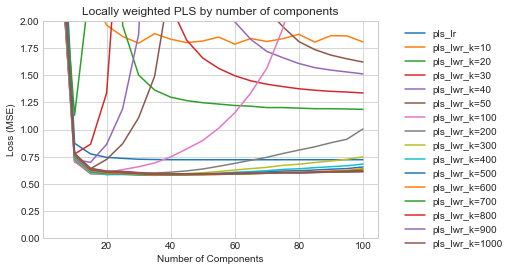

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PLS by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_pls.png",bbox_inches='tight')

ax.set_ylim(0,2)
plt.savefig(log_dir / f"mse_plot_pls_compressed.png",bbox_inches='tight')


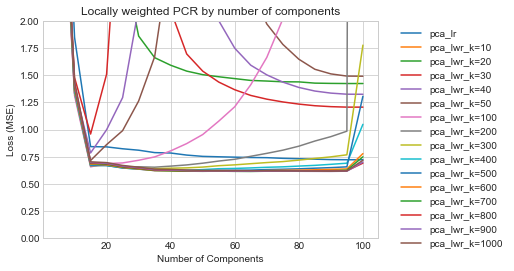

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PCR by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_pca.png",bbox_inches='tight')

ax.set_ylim(0,2)
plt.savefig(log_dir / f"mse_plot_pca_compressed.png",bbox_inches='tight')


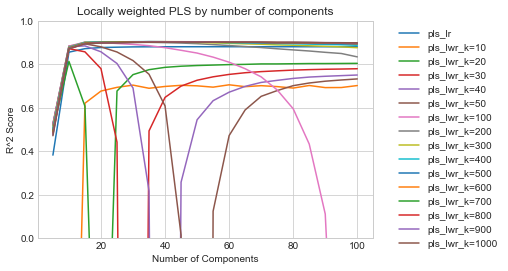

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PLS by number of components")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pls.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pls_v2.png",bbox_inches='tight')


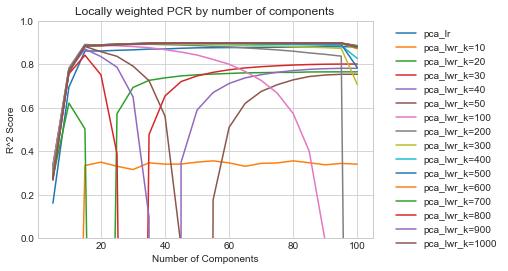

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PCR by number of components")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pcr.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pcr_v2.png",bbox_inches='tight')


In [16]:
#https://stackoverflow.com/questions/22521382/nonlinear-colormap-matplotlib

class nlcmap(object):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)

In [17]:
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
print(levels)
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)

[0.   0.6  0.8  0.9  0.95 0.98 1.  ]


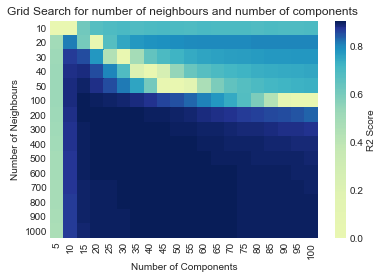

In [20]:
import seaborn as sns

subset = scores_df_pls[["model","n_comp","R2"]]
subset = subset[np.logical_not(subset["model"]=="pls_lr")]
trans = subset["model"].transform(lambda x: int(x.replace("pls_lwr_k=",""))).tolist()

subset.loc[:,"model"]=trans
subset=subset.sort_values("model",ascending=False)
wide = subset.pivot(index = "model",columns= "n_comp",values="R2")

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours and number of components ")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Number of Neighbours")

plt.savefig(log_dir/"pls_heatmap.png", bbox_inches='tight')

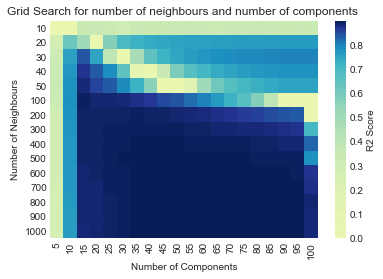

In [21]:
subset = scores_df_pcr[["model","n_comp","R2"]]
subset = subset[np.logical_not(subset["model"]=="pca_lr")]
trans = subset["model"].transform(lambda x: int(x.replace("pca_lwr_k=",""))).tolist()

subset.loc[:,"model"]=trans
subset=subset.sort_values("model",ascending=False)
wide = subset.pivot(index = "model",columns= "n_comp",values="R2")

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours and number of components ")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Number of Neighbours")

plt.savefig(log_dir/"pca_heatmap.png", bbox_inches='tight')